# Two-Fluids SBN with input gaussian and analytical axicon - loop

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os

import sys
sys.path.append(r'E:\Nonlinear_Optics_LAB\LAB_Repository\Tiago_Code\lab-logbooks\LAB_base_methods_temp')

%aimport slm_controllers
%aimport camera_controllers
%aimport RC_methods


from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from core_libs.functions_for_initial_conditions import *
from core_libs.functions_for_fit import *
from core_libs.turbulence_methods import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
from matplotlib.colors import ListedColormap

from scipy import optimize
from scipy import interpolate
import scipy as sp
from IPython.display import Markdown, display
from scipy.special import jv, jn
import enlighten

import h5py

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

def printmd(string, color=None):
    colorstr = "#### <span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

# <font color='green'>Load Gaussian beam</font>

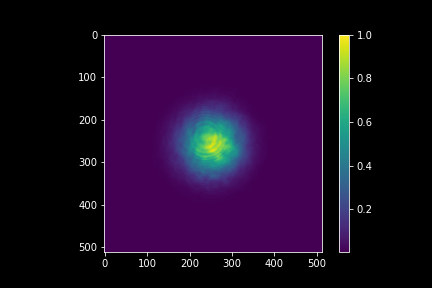

In [5]:
%matplotlib widget

path_to_load = r"E:\Nonlinear_Optics_LAB\Tiago_Data\Fuid_plus_obstacle_turbulence\measurements _03_06_2022"
 
path_temp = path_to_load +  "\\input_gaussian_beam"
h5py_file_to_load = h5py.File(path_temp, 'r')
input_fluid= h5py_file_to_load["data"][:]
h5py_file_to_load.close()


input_fluid_normalized = input_fluid/np.max(input_fluid)

y_shape, x_shape = np.shape(input_fluid_normalized)

x_center = 531
y_center = 261


input_fluid_normalized_rolled = np.roll(input_fluid_normalized, 
                                        (int(y_shape/2-y_center),int(x_shape/2-x_center)), (0,1))

input_fluid_normalized_rolled_cutted = input_fluid_normalized_rolled[(int(y_shape/2-256)):(int(y_shape/2+256)),
                                                                     (int(x_shape/2-256)):(int(x_shape/2+256))]

plt.figure()

plt.imshow(input_fluid_normalized_rolled_cutted)
plt.colorbar()

# <font color='green'>System characterization</font>

In [6]:
%matplotlib widget
#%matplotlib inline

R = ((2.36-1)/(2.36+1))**2.0
T = 1 - R

#Scaling factor of the power meter
power_meter_factor = 1.34+1.6*0

GL_to_load = [0, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 15000]
angle = [0, 0.00244017, 0.00280785, 0.00476556, 0.00679314, 0.0090616, 0.01050736, 0.01238871, 0.013732, 0.01519613, 0.01677856, 0.02503264]


popt_x_ve, pcov_x = sp.optimize.curve_fit(linear_fit, GL_to_load, angle, p0=[0.001, 0.0])

N_rings_level_2 = [0, 1, 1, 2, 4, 6, 6, 7, 7]
max_or_minimum_level_2 = [1, 0, 1, 1, 0, 0, 1, 1, 1]

delta_phi_level_2 = np.zeros(len(N_rings_level_2))

for i in range(len(delta_phi_level_2)):
    if max_or_minimum_level_2[i]==1:
        delta_phi_level_2[i] = 2.0*N_rings_level_2[i]*np.pi
    else:
        delta_phi_level_2[i] = 2.0*(N_rings_level_2[i]-1)*np.pi
        
k0 = 2.0*np.pi/(532e-9) 
L = 20e-3
delta_n_level_2 = delta_phi_level_2/(k0*L)

power_to_load_level_2 = [0.553, 2.02, 5.86, 12.72, 29.6, 78.1, 192, 512, 961]
intensities_level_2 = 2.0*np.array(power_to_load_level_2)*power_meter_factor*1e-3/(np.pi*(0.0245)**2.0)

intensities_level_2 *= T

delta_n_params, pcov_x = sp.optimize.curve_fit(delta_n_f, intensities_level_2, delta_n_level_2, p0=[1e-4,25])

# <font color='green'>System configuration</font>

In [9]:
GL_to_compute = [0, 1500, 2000, 3000, 4000, 5000, 7000] 
power_dictionary = {"0":47.1, "1500":46.6, "2000":46.5, "3000":45.9, 
                  "4000":45.1, "5000":44.7, "7000":44.1}


for i in range(len(GL_to_compute)):
    print(i)

    ###################################################################################
    #Velocity of the fluid
    GL = GL_to_compute[i]


    P_green_beam = power_dictionary[str(GL)] #muW
    P_green_beam_corrected = power_meter_factor*P_green_beam

    #Red beam parameters
    P_red_beam = 50.1#muW

    #########################################################################################################

    P_green_beam_corrected *= T
    P_red_beam *= T


    norm = np.sum(input_fluid_normalized_rolled_cutted)*(3.45e-6*2.0)**2.0*1e4

    I_fluid = P_green_beam_corrected*1e-3/norm
    
    #light fluid wavelength
    lf=532*10**-9

    #k_fluid
    kf = (2*pi)/lf

    #parameters of the crystal
    ne = 2.36 #index of refraction n_e
    r33 = 235*10**-12 #pm/V
    #Biasing electric Field
    E0 = 1400*10**2 # V/m

    #maximum index variation
    #delta_n_max = 0.5*ne**3*r33*E0
    delta_n_max = delta_n_params[0]
    delta_n = delta_n_f(I_fluid, *delta_n_params)


    #absorption
    alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
    gamma = 1

    #healing length
    hl = 1/(kf*sqrt(ne*delta_n))

    #transverse direction scaling factor
    factor_t = kf*sqrt(ne*delta_n_max)

    #propagation direction scaling factor
    factor_z = kf*delta_n_max


    ##################################################
    #Crystal Size
    lx=512*3.45*1e-6*2.0 #2.5*10**-3
    ly=512*3.45*1e-6*2.0 #2.5*10**-3
    lz=20*10**-3

    #in adimensional units
    lx_sim = factor_t*lx
    ly_sim = factor_t*ly
    lz_sim = factor_z*lz
    
    #number of transversal dimensions (only working 1 and 2, necessary for plotting)
    dims = 2

    #Number of points in x,y transversal dimensions
    Nx = 512
    Ny = 512

    #do not change Nt, Nz
    Nt = 1 
    Nz = 1

    #spatial steps
    dx = lx_sim / Nx
    dy = ly_sim / Ny
    dt = 1.
    print('dx->',dx,'dy->',dy)

    #integration parameters

    stride = 50
    dz = 0.05 #.2
    total_steps = int(lz_sim/(stride*dz))
    print(total_steps)

    #define a directory to save
    saveDir = r".turbulence_photorefractive_with_gaussian_image_an_axicon_loop/GL_" + str(GL)

    if Nx != 512 and Ny!=512:
        print("The fields will be interpolated")
        y_shape, x_shape = np.shape(input_fluid_normalized_rolled_cutted)
        xx_camera = np.linspace(0, x_shape, x_shape)
        yy_camera = np.linspace(0, y_shape, y_shape)

        fluid_interpolator = interpolate.interp2d(xx_camera, yy_camera, input_fluid_normalized_rolled_cutted, kind='cubic')

        XX_new = np.linspace(0, x_shape, Nx)
        YY_new = np.linspace(0, y_shape, Ny)

        fluid_rescaled = fluid_interpolator(XX_new, YY_new)

        input_fluid_normalized_cutted_scalled = fluid_rescaled

    else:
        print("No interpolation")
        input_fluid_normalized_cutted_scalled = input_fluid_normalized_rolled_cutted
    
    
    #Simulation parameters
    d_bessel = 121.6e-4
    dd = d_bessel*1e-2*factor_t/2.0

    ######Green beam intensity
    norm = np.sum(np.abs(np.sqrt(input_fluid_normalized_cutted_scalled))**2.0)*dx*dy/factor_t/factor_t*1e4
    I_green_beam = P_green_beam_corrected*1e-3/norm

    print(I_green_beam)
    delta_n = delta_n_f(I_green_beam, *delta_n_params)


    theta = linear_fit(GL, *popt_x_ve)
    vx = theta/ne/np.sqrt(ne*delta_n)
    if vx <0:
        vx = 0
    cs = np.sqrt(delta_n/ne)
    gamma = 1

    Isat = delta_n_params[-1]/I_green_beam #mw/cm^-2

    print("vx = " + str(vx))
    print("vx/cs = " + str(theta/ne/cs))

    my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                      stride,dx,dy,dz,dt,0,0, 
                                      alpha, Isat, gamma, saveDir)

    #Gaussian field - fluid
    my_simulation.initial_condition.add_field(add_field_from_array_with_velocity_normalized(np.sqrt(input_fluid_normalized_cutted_scalled),
                                                                                 my_simulation.x_af,
                                                                                 my_simulation.y_af, 
                                                                                 P_green_beam_corrected*1e-3,
                                                                                 I_green_beam,
                                                                                 my_simulation.Nx*my_simulation.dx/2, 
                                                                                 my_simulation.Ny*my_simulation.dy/2,
                                                                                 vx,
                                                                                 0,
                                                                                 factor_t))

    #Noise
    my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af, 0.1))


    #Axicon - optical defect
    # my_simulation.initial_condition2.add_field(add_field_from_array_with_velocity_normalized(np.abs(input_axicon_normalized_cutted_scalled),
    #                                                                                my_simulation.x_af,
    #                                                                                my_simulation.y_af, 
    #                                                                                P_red_beam*1e-3,
    #                                                                                I_green_beam,
    #                                                                                my_simulation.Nx*my_simulation.dx/2,
    #                                                                                my_simulation.Ny*my_simulation.dy/2,
    #                                                                                0,
    #                                                                                0,
    #                                                                                factor_t))

    my_simulation.initial_condition2.add_field(bessel_2d(my_simulation.x_af,
                                                         my_simulation.y_af, 
                                                         P_red_beam*1e-3,
                                                         I_green_beam,
                                                         my_simulation.Nx*dx/2,
                                                         my_simulation.Ny*dy/2, 
                                                         dd,
                                                         factor_t))
    #how many
    number_nl_numbers = 0
    #(g, power)
    nl_numbers = []
    my_simulation.number_nl_numbers = number_nl_numbers

    #define the nonlinearities of type vector
    #how many
    number_nl_vectors = 0
    nl_vectors=[]
    my_simulation.number_nl_vectors = number_nl_vectors
    
    my_simulation.gen_config_file(nl_numbers,nl_vectors)
    
    af.device.set_device(0)
    af.device.device_info()
    
    #%%cmd
    ! hibpm_run.exe 2 0 

0
dx-> 1.753741076189791 dy-> 1.753741076189791
18
No interpolation
8.74667434716213
vx = 0
vx/cs = -0.15309685725121572
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
Running info
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 18 aqui:0.05
aqui
update Stride 1 of 18 aqui:0.05
aqui
update Stride 2 of 18 aqui:0.05
aqui
update Stride 3 of 18 aqui:0.05
aqui
update Stride 4 of 18 aqui:0.05
aqui
update Stride 5 of 18 aqui:0.05
aqui
update Stride 6 of 18 aqui:0.05
aqui
update Stride 7 of 18 aqui:0.05
aqui
update Stride 8 of 18 aqui:0.05
aqui
update Stride 9 of 18 aqui:0.05
aqui
update Stride 10 of 18 aqui:0.05
aqui
update Stride 11 of 18 aqui:0.05
aqui
update Stride 12 of 18 aqui:0.05
aqui
update Stride 13 of 18 aqui:0.05
aqui
update Stride 14 of 18 aq